From Rxx, and Gideon, I learned about this applied SME signal boosting on quadradic funding. 

It means that the quadradic funding algorithm is weighted heavier from donors that qualify as SME.

Congrats to the TEC coordination team for pulling this off. They pulled this off on round 1.

Let's apply engineering to this process.

Engineering is about the production of artifacts in a safe and ethical way. 

Artifacts have interfaces that people may use. Engineering allows the usage of interfaces without bad things happening.



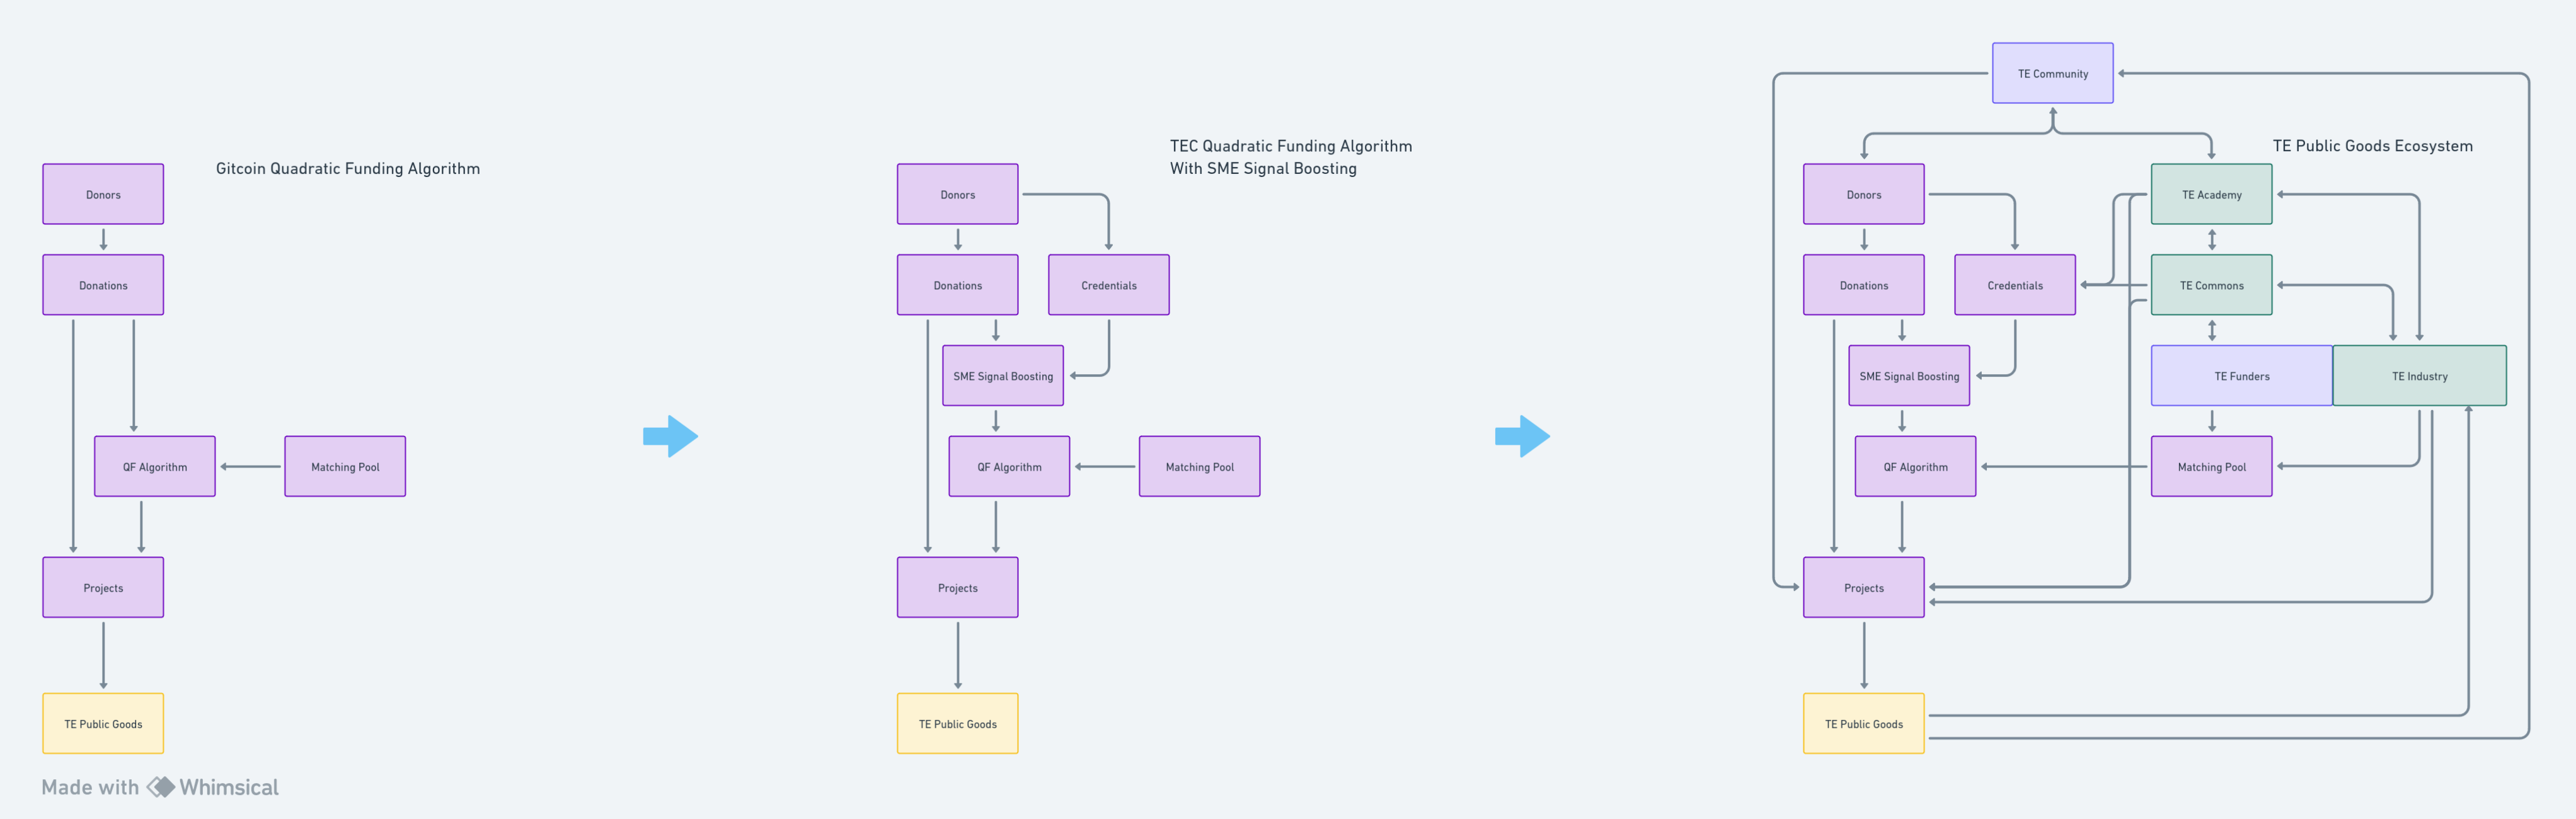![image.png]()

Link to the above board: https://whimsical.com/original-qfsme-mechanism-flowchart-QjXRdbkFmBcXBhnV175K9z 

Resources


* https://arxiv.org/pdf/2010.01193.pdf
* https://arxiv.org/pdf/1809.06421.pdf
* https://vitalik.ca/general/2019/12/07/quadratic.html
* https://qf.gitcoin.co/?grant=&grant=&grant=&match=1000
* https://medium.com/token-engineering-commons/expertise-and-quadratic-funding-bd4f0c5c3e23 

## A Flexible Design for Funding Public Goods

https://arxiv.org/pdf/1809.06421.pdf

### 3.0 Model

In [1]:
import numpy as np

# Number of Citizens in the Society
N = 300

# Society is a set of citizens
society = set(range(N))

# Community is a random subset of the society. The community size is from 1 up to 1/2 of the society.
community = np.random.choice(a=list(society), size=np.random.randint(1, len(society)/2), replace=False, p=None)

# Public Goods are proposed by community members. Cardinality is from 0 up to 1/2 size of the community.
public_goods = list(enumerate(np.random.choice(a=list(community), size=np.random.randint(0, len(community)/2), replace=True, p=None)))

In [2]:
community

array([ 28, 128, 138, 108, 192,   8, 247, 280,  20, 163, 233, 263, 219,
        99, 115, 185, 144, 296, 257, 104,  25, 151, 237,  53, 154,  90,
       140, 225,  50, 168,  86, 149, 231, 229,  27,   9, 129,  11, 274,
        55, 248, 244,  37, 292, 215,  24,  46, 253, 217, 119, 232,  60,
       266, 224, 114, 207, 157, 262, 195, 205, 285, 269, 250, 197, 194,
       170,  47,  98,  33,  64])

In [3]:
public_goods

[(0, 25),
 (1, 149),
 (2, 197),
 (3, 149),
 (4, 20),
 (5, 185),
 (6, 50),
 (7, 185),
 (8, 47),
 (9, 257)]

In [4]:
len(society)

300

In [5]:
len(community)

70

In [6]:
len(public_goods)

10

### 3.1 Individual Preferences and Actions

In [7]:
import param as pm




class Value(pm.Parameterized):
    citizen_i = pm.Integer()
    public_good_p = pm.Tuple()
    value_map = pm.DataFrame(columns=['citizen', 'public_good', 'value'])
    value_functions = []
    
    def F(self, x):
        return x
    
    def currency_utility(funding_p: float) -> float:
        return self.__getattr__['F'](funding_p)

In [8]:
class Value(pm.Parameterized):
    funding = pm.Magnitude()

### 3.1 Side Quest: Generating Value Functions

Polynomial generator.

In [9]:
c1 = {'exponent': 1,
 'f0': 0.2,
 'f1': 0.8,
 'initial_slope': 1,
 'name': 'CurveGenerator18499',
 'num_oscillations': 2}

In [10]:
import param
import numpy as np
import pandas as pd
import hvplot.pandas
import panel as pn

class CurveGenerator(param.Parameterized):
    f0 = param.Number(default=0.2, bounds=(0, 1), doc="Value of f(0)")
    f1 = param.Number(default=0.8, bounds=(0, 1), doc="Value of f(1)")
    initial_slope = param.Number(default=1, bounds=(-5, 5), doc="Initial slope of the curve")
    exponent = param.Number(default=1, bounds=(1, 5), doc="Exponent of the curve")
    num_oscillations = param.Integer(default=1, bounds=(0, 5), doc="Number of oscillations/peaks in the curve")
    
    @param.depends('f0', 'f1', 'initial_slope', 'exponent', 'num_oscillations')
    def curve(self, x):
        epsilon = 1e-10
        b = self.f0
        a = self.initial_slope / (self.exponent * (b + epsilon)**(self.exponent-1))
        c = (self.f1 - self.f0 - a) / 2
        d = self.num_oscillations
        y = a*x**self.exponent + b + c*np.sin(d*np.pi*x)
        
        # Scale and shift the curve to ensure it starts at f0 and ends at f1
        y = self.f0 + (self.f1 - self.f0) * (y - y.min()) / (y.max() - y.min())
        
        return y
    
    @param.depends('f0', 'f1', 'initial_slope', 'exponent', 'num_oscillations')
    def view(self):
        x = np.linspace(0, 1, 100)
        y = self.curve(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01))

curve_gen = CurveGenerator(**c1)
pn.Row(curve_gen.param, curve_gen.view).servable()


%opts magic unavailable (pyparsing cannot be imported)
%compositor magic unavailable (pyparsing cannot be imported)


Row
    [0] Column(margin=(5, 10), name='CurveGenerator')
        [0] StaticText(value='<b>CurveGenerator</b>')
        [1] FloatSlider(name='F0', value=0.2)
        [2] FloatSlider(name='F1', value=0.8)
        [3] FloatSlider(end=5, name='Initial slope', start=-5, value=1)
        [4] FloatSlider(end=5, name='Exponent', start=1, value=1)
        [5] IntSlider(end=5, name='Num oscillations', value=2)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

In [11]:
curve_gen.param.values()

{'exponent': 1,
 'f0': 0.2,
 'f1': 0.8,
 'initial_slope': 1,
 'name': 'CurveGenerator18499',
 'num_oscillations': 2}

Sigmoid Generator

In [12]:
s1 = {'exponent': 0.3,
 'f0': 0,
 'f1': 0.5,
 'initial_slope': -5,
 'name': 'SigmoidGenerator03300',
 'oscillations': 2}

s2 = {'exponent': 0.4,
 'f0': 0,
 'f1': 0.5,
 'initial_slope': 4.4,
 'name': 'SigmoidGenerator03300',
 'oscillations': 2}

In [13]:
import numpy as np
import pandas as pd
import panel as pn
import param
import hvplot.pandas

class SigmoidGenerator(param.Parameterized):
    f0 = param.Number(default=0.5, bounds=(0, 1), doc="Value of the function at x=0")
    f1 = param.Number(default=0.5, bounds=(0, 1), doc="Value of the function at x=1")
    initial_slope = param.Number(default=1, bounds=(-5, 5), doc="Initial slope of the curve")
    exponent = param.Number(default=0.3, bounds=(0.1, 0.5), doc="Exponent of the curve")
    oscillations = param.Integer(default=1, bounds=(1, 5), doc="Number of oscillations/peaks in the curve")
    
    @param.depends('f0', 'f1', 'initial_slope', 'exponent', 'oscillations')
    def view(self):
        x = np.linspace(0, 1, 400)
        y = self.f0 + (self.f1 - self.f0) / (1 + np.exp(-self.initial_slope * (x - 0.5) * 10))**self.exponent
        y = y + 0.1 * np.sin(self.oscillations * np.pi * x)
        
        # Clip y values to ensure they stay within [0, 1]
        y = np.clip(y, 0, 1)
        
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(-0.01, 1.01))

sigmoid_gen = SigmoidGenerator(**s2)
pn.Row(sigmoid_gen.param, sigmoid_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='SigmoidGenerator')
        [0] StaticText(value='<b>SigmoidGenerator</b>')
        [1] FloatSlider(name='F0')
        [2] FloatSlider(name='F1', value=0.5)
        [3] FloatSlider(end=5, name='Initial slope', start=-5, value=4.4)
        [4] FloatSlider(end=0.5, name='Exponent', start=0.1, value=0.4)
        [5] IntSlider(end=5, name='Oscillations', start=1, value=2)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

In [14]:
sigmoid_gen.param.values()

{'exponent': 0.4,
 'f0': 0,
 'f1': 0.5,
 'initial_slope': 4.4,
 'name': 'SigmoidGenerator03300',
 'oscillations': 2}

In [15]:
p1 = {'exponent_param': 0.2,
 'f0': 0.1,
 'f1': 0.8,
 'name': 'PowerFunctionGenerator22564'}

In [16]:
import numpy as np
import pandas as pd
import panel as pn
import param
import hvplot.pandas

class PowerFunctionGenerator(param.Parameterized):
    f0 = param.Number(default=0.1, bounds=(0, 1), doc="Value of the function at x=0")
    f1 = param.Number(default=0.5, bounds=(0, 1), doc="Value of the function at x=1")
    exponent_param = param.Number(default=0.5, bounds=(0.1, 2), doc="Parameter determining the exponent and slope")
    
    @param.depends('f0', 'f1', 'exponent_param')
    def view(self):
        epsilon = 1e-10

        x = np.linspace(0.001, 1, 400)  # Start from 0.001 to avoid division by zero
        
        # Calculate the exponent based on the provided parameter
        b = 2 * self.exponent_param  # This maps [0, 1] to [0, 2] for the exponent
        
        # Using the conditions f(0) = f0 and f(1) = f1 to solve for 'a' and 'c'
        a = self.f0
        c = (self.f1 - self.f0) / (1 ** b - 0 ** b + epsilon)
        
        y = a + c * x ** b
        
        # Clip y values to ensure they stay within [0, 1]
        y = np.clip(y, 0, 1)
        
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01))

power_func_gen = PowerFunctionGenerator(**p1)
pn.Row(power_func_gen.param, power_func_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='PowerFunctionGenerator')
        [0] StaticText(value='<b>PowerFunctionGenerator...)
        [1] FloatSlider(name='F0', value=0.1)
        [2] FloatSlider(name='F1', value=0.8)
        [3] FloatSlider(end=2, name='Exponent param', start=0.1, value=0.2)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

In [17]:
power_func_gen.param.values()

{'exponent_param': 0.2,
 'f0': 0.1,
 'f1': 0.8,
 'name': 'PowerFunctionGenerator22564'}

In [18]:
import numbergen as ng

# For CurveGenerator
polynomial_curve_generator_params = dict(
    f0=ng.UniformRandom(lbound=0, ubound=1)(),
    f1=ng.UniformRandom(lbound=0, ubound=1)(),
    initial_slope=ng.UniformRandom(lbound=-5, ubound=5)(),
    exponent=ng.UniformRandom(lbound=1, ubound=5)(),
    num_oscillations=int(ng.UniformRandom(lbound=0, ubound=5)())
)

# For SigmoidGenerator
sigmoid_curve_generator_params = dict(
    f0=ng.UniformRandom(lbound=0, ubound=1)(),
    f1=ng.UniformRandom(lbound=0, ubound=1)(),
    initial_slope=ng.UniformRandom(lbound=-5, ubound=5)(),
    exponent=ng.UniformRandom(lbound=0.1, ubound=0.5)(),
    oscillations=int(ng.UniformRandom(lbound=1, ubound=5)())
)

# For PowerFunctionGenerator
power_curve_generator_params = dict(
    f0=ng.UniformRandom(lbound=0, ubound=1)(),
    f1=ng.UniformRandom(lbound=0, ubound=1)(),
    exponent_param=ng.UniformRandom(lbound=0.1, ubound=2)()
)

# Now, you can use these dictionaries to create instances of your classes as you've done in your code.


In [19]:
import numbergen as ng

# For CurveGenerator
polynomial_curve_generator_params = {
    'f0': ng.UniformRandom(lbound=0, ubound=0.5)(),
    'f1': ng.UniformRandom(lbound=0, ubound=1)(),
    'initial_slope': ng.UniformRandom(lbound=-5, ubound=5)(),
    'exponent': ng.UniformRandom(lbound=1, ubound=5)(),
    'num_oscillations': int(ng.UniformRandom(lbound=0, ubound=5)())
}

# For SigmoidGenerator
sigmoid_curve_generator_params = {
    'f0': ng.UniformRandom(lbound=0, ubound=0.5)(),
    'f1': ng.UniformRandom(lbound=0, ubound=1)(),
    'initial_slope': ng.UniformRandom(lbound=-5, ubound=5)(),
    'exponent': ng.UniformRandom(lbound=0.1, ubound=0.5)(),
    'oscillations': int(ng.UniformRandom(lbound=0, ubound=5)())
}

# For PowerFunctionGenerator
power_curve_generator_params = {
    'f0': ng.UniformRandom(lbound=0, ubound=0.5)(),
    'f1': ng.UniformRandom(lbound=0, ubound=1)(),
    'exponent_param': ng.UniformRandom(lbound=0.1, ubound=2)()
}

In [20]:
# Instantiate CurveGenerator with polynomial_curve_generator_params
polynomial_curve_gen_instance = CurveGenerator(**polynomial_curve_generator_params)

polynomial_curve_gen_instance.view()


:Curve   [x]   (y)

In [21]:
# Instantiate SigmoidGenerator with sigmoid_curve_generator_params
sigmoid_curve_gen_instance = SigmoidGenerator(**sigmoid_curve_generator_params)
sigmoid_curve_gen_instance.view()

:Curve   [x]   (y)

In [22]:
# Instantiate PowerFunctionGenerator with power_curve_generator_params
power_curve_gen_instance = PowerFunctionGenerator(**power_curve_generator_params)
power_curve_gen_instance.view()

:Curve   [x]   (y)

In [23]:
value_generators = [
    (CurveGenerator, polynomial_curve_generator_params),
    (SigmoidGenerator, sigmoid_curve_generator_params),
    (PowerFunctionGenerator, power_curve_generator_params),
]

# Generate a random index
index = np.random.choice(len(value_generators))

# Use the index to select an item from value_generators
selected_generator = value_generators[index]

In [24]:
index

1

In [25]:
selected_generator

(__main__.SigmoidGenerator,
 {'f0': 0.21198525033877902,
  'f1': 0.2747909961336312,
  'initial_slope': 2.821016015705128,
  'exponent': 0.2041606770562158,
  'oscillations': 3})

In [26]:
selected_generator[0]

__main__.SigmoidGenerator

In [27]:
selected_generator[0](**selected_generator[1])

SigmoidGenerator(exponent=0.2041606770562158, f0=0.21198525033877902, f1=0.2747909961336312, initial_slope=2.821016015705128, name='SigmoidGenerator01704', oscillations=3)

In [28]:
import numbergen as ng
import numpy as np


# For CurveGenerator
polynomial_curve_generator_params = dict(
    f0=ng.UniformRandom(lbound=0, ubound=1)(),
    f1=ng.UniformRandom(lbound=0, ubound=1)(),
    initial_slope=ng.UniformRandom(lbound=-5, ubound=5)(),
    exponent=ng.UniformRandom(lbound=1, ubound=5)(),
    num_oscillations=int(ng.UniformRandom(lbound=0, ubound=5)())
)

# For SigmoidGenerator
sigmoid_curve_generator_params = dict(
    f0=ng.UniformRandom(lbound=0, ubound=1)(),
    f1=ng.UniformRandom(lbound=0, ubound=1)(),
    initial_slope=ng.UniformRandom(lbound=-5, ubound=5)(),
    exponent=ng.UniformRandom(lbound=0.1, ubound=0.5)(),
    oscillations=int(ng.UniformRandom(lbound=1, ubound=5)())
)

# For PowerFunctionGenerator
power_curve_generator_params = dict(
    f0=ng.UniformRandom(lbound=0, ubound=1)(),
    f1=ng.UniformRandom(lbound=0, ubound=1)(),
    exponent_param=ng.UniformRandom(lbound=0.1, ubound=2)()
)

# Now, you can use these dictionaries to create instances of your classes as you've done in your code.
value_generators = np.array([
    (CurveGenerator, polynomial_curve_generator_params),
    (SigmoidGenerator, sigmoid_curve_generator_params),
    (PowerFunctionGenerator, power_curve_generator_params),
])

# Generate a random array of indices of length n
samples = np.random.choice(len(value_generators), size=len(public_goods)*len(society))

# Use numpy's advanced indexing to obtain the selected_generators
sampled_generators = value_generators[samples]

# Instantiate utility curves using python param and numbergen
sampled_utility = [Generator(**params) for Generator, params in sampled_generators]

In [29]:
sampled_utility[:5]

[SigmoidGenerator(exponent=0.3533176876270915, f0=0.6975702271909845, f1=0.5813058051497462, initial_slope=1.7145454539638036, name='SigmoidGenerator01718', oscillations=2),
 PowerFunctionGenerator(exponent_param=1.0684610613420922, f0=0.41500028365182473, f1=0.7935491351750461, name='PowerFunctionGenerator01719'),
 CurveGenerator(exponent=2.1789852352740744, f0=0.36530684021508675, f1=0.09911734009998785, initial_slope=2.551427941334003, name='CurveGenerator01720', num_oscillations=0),
 PowerFunctionGenerator(exponent_param=1.0684610613420922, f0=0.41500028365182473, f1=0.7935491351750461, name='PowerFunctionGenerator01721'),
 SigmoidGenerator(exponent=0.3533176876270915, f0=0.6975702271909845, f1=0.5813058051497462, initial_slope=1.7145454539638036, name='SigmoidGenerator01722', oscillations=2)]

In [30]:
import pandas as pd

pd.DataFrame([s.param.values() for s in sampled_utility])

,exponent,f0,f1,initial_slope,name,oscillations,exponent_param,num_oscillations
0,0.353318,0.697570,0.581306,1.714545,SigmoidGenerator01718,2.0,NaN,NaN
1,NaN,0.415000,0.793549,NaN,PowerFunctionGenerator01719,NaN,1.068461,NaN
2,2.178985,0.365307,0.099117,2.551428,CurveGenerator01720,NaN,NaN,0.0
3,NaN,0.415000,0.793549,NaN,PowerFunctionGenerator01721,NaN,1.068461,NaN
4,0.353318,0.697570,0.581306,1.714545,SigmoidGenerator01722,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2995,0.353318,0.697570,0.581306,1.714545,SigmoidGenerator04713,2.0,NaN,NaN
2996,NaN,0.415000,0.793549,NaN,PowerFunctionGenerator04714,NaN,1.068461,NaN
2997,NaN,0.415000,0.793549,NaN,PowerFunctionGenerator04715,NaN,1.068461,NaN
2998,NaN,0.415000,0.793549,NaN,PowerFunctionGenerator04716,NaN,1.068461,NaN


In [31]:
sample_p_i = pn.widgets.IntSlider(name='Utility Value Function', start=0, end=len(sampled_utility)-1)

In [32]:
sample_p_i

IntSlider(end=2999, name='Utility Value Function')

In [33]:
pn.Row(sample_p_i, pn.bind(lambda i: sampled_utility[i].view(), i=sample_p_i.param.value_throttled))

Row
    [0] IntSlider(end=2999, name='Utility Value Function')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [34]:
import param
import numpy as np
import pandas as pd
import hvplot.pandas
import panel as pn

class CurveGenerator(param.Parameterized):
    # ... [Parameters remain unchanged]
    
    def x(self):
        return np.linspace(0, 1, 400)
    
    def f(self, x):
        epsilon = 1e-10
        b = self.f0
        a = self.initial_slope / (self.exponent * (b + epsilon)**(self.exponent-1))
        c = (self.f1 - self.f0 - a) / 2
        d = self.num_oscillations
        y = a*x**self.exponent + b + c*np.sin(d*np.pi*x)
        
        # Scale and shift the curve to ensure it starts at f0 and ends at f1
        y = self.f0 + (self.f1 - self.f0) * (y - y.min()) / (y.max() - y.min())
        return y
    
    @param.depends('f0', 'f1', 'initial_slope', 'exponent', 'num_oscillations')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01), width=500, height=400)

# ... [Initialization remains unchanged]

class SigmoidGenerator(param.Parameterized):
    # ... [Parameters remain unchanged]
    
    def x(self):
        return np.linspace(0, 1, 400)
    
    def f(self, x):
        y = self.f0 + (self.f1 - self.f0) / (1 + np.exp(-self.initial_slope * (x - 0.5) * 10))**self.exponent
        y = y + 0.1 * np.sin(self.oscillations * np.pi * x)
        
        # Clip y values to ensure they stay within [0, 1]
        y = np.clip(y, 0, 1)
        return y
    
    @param.depends('f0', 'f1', 'initial_slope', 'exponent', 'oscillations')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(-0.01, 1.01))

# ... [Initialization remains unchanged]

class PowerFunctionGenerator(param.Parameterized):
    # ... [Parameters remain unchanged]
    
    def x(self):
        return np.linspace(0.001, 1, 400)  # Start from 0.001 to avoid division by zero
    
    def f(self, x):
        epsilon = 1e-10
        b = 2 * self.exponent_param  # This maps [0, 1] to [0, 2] for the exponent
        a = self.f0
        c = (self.f1 - self.f0) / (1 ** b - 0 ** b + epsilon)
        y = a + c * x ** b
        
        # Clip y values to ensure they stay within [0, 1]
        y = np.clip(y, 0, 1)
        return y
    
    @param.depends('f0', 'f1', 'exponent_param')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01))

# ... [Initialization remains unchanged]


In [35]:
[s.f(s.x()) for s in sampled_utility[:5]]

AttributeError: 'SigmoidGenerator' object has no attribute 'f'